# Second and Third Stages Of Training:

## Second Stage:

In this stage, we freeze the CNN weights and train the fully connected layers with all four branches active

## Third Stage:
In the third and final stage, we use the feature extraction part of four networks, which were trained in the first stage, to create a multi-branch network. We then freeze three branches at a time and train one branch, along with the fully connected part of the network. This process is repeated for each branch, training one at a time.

## Preproccessing

Import Libraries

In [ ]:
## Importing Libs:
##
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Dense, Dropout, Input, MaxPooling2D  , Softmax, Flatten , Concatenate ,Conv2D, BatchNormalization
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from google.colab import drive
drive.mount('/content/drive')
import glob
from PIL import Image
from tensorflow import keras
import gc
from keras.utils.layer_utils import count_params
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , ConfusionMatrixDisplay
from keras.callbacks import ReduceLROnPlateau
path = '/content/drive/MyDrive/KCN/Semi_Final/'

##

Mounted at /content/drive


Load Data

In [ ]:
## Importing Data:
x1 = np.load(path+'x1.npy')   #Post Elevation BFTA
x2 = np.load(path+'x2.npy')   #Ant Elevation BFTA
x3 = np.load(path+'x3.npy')   #Inst-CURV-ant#
x4 = np.load(path+'x4.npy')   #PACHY
Y= np.load(path+'Y.npy')
##

Center Crop:

In [ ]:
###
def center_crop(pic_array,pic_size):
  initial_size = pic_array.shape[1]
  new_pic_array =np.zeros((len(pic_array),pic_size,pic_size,3),dtype=np.uint8)
  for i in range(len(pic_array)):
    new_pic_array[i,:] = pic_array[i,(initial_size-pic_size)//2:initial_size-(initial_size-pic_size)//2,(initial_size-pic_size)//2:initial_size-(initial_size-pic_size)//2,:]

  del pic_array
  gc.collect()

  return new_pic_array
  del new_pic_array
  gc.collect()
  ###

In [ ]:
###
x_1=center_crop(x1,224)
x_2=center_crop(x2,224)
x_3=center_crop(x3,224)
x_4=center_crop(x4,224)
###

Extract KCN and Normal Data:

In [ ]:
###
X_1 = np.zeros((len(Y),224,224,3),dtype=np.uint8)
X_2 = np.zeros((len(Y),224,224,3),dtype=np.uint8)
X_3 = np.zeros((len(Y),224,224,3),dtype=np.uint8)
X_4 = np.zeros((len(Y),224,224,3),dtype=np.uint8)
X_5 = np.zeros((len(Y),14))

j=0
for i in range(len(Y)):
  if(Y[i]==0):
    X_1[j,:]=x_1[i,:]
    X_2[j,:]=x_2[i,:]
    X_3[j,:]=x_3[i,:]
    X_4[j,:]=x_4[i,:]

    j=j+1

  if(Y[i]==1):
    X_1[j,:]=x_1[i,:]
    X_2[j,:]=x_2[i,:]
    X_3[j,:]=x_3[i,:]
    X_4[j,:]=x_4[i,:]

    j=j+1
###

One-Hot Out Put:

In [ ]:
###
y_c = np.zeros((len(Y),2))
for i in range (len(Y)) :
  if (Y[i]==0):
    y_c[i,0] = 1
  if (Y[i]==1):
    y_c[i,1]=1
###

In [ ]:
### generate id:
id = np.zeros(len(Y))
for i in range(len(Y)):
  id[i]=i
###

Train Test Split:

In [ ]:
###
X1_tr,X1_te,X2_tr,X2_te,X3_tr,X3_te,X4_tr,X4_te, y_tr, y_te,id_tr,id_te = train_test_split(X_1,X_2,X_3,X_4,y_c,id,test_size=0.1, random_state=12)
###

Freeup Memory

In [ ]:
###
del x1,x2,x3,x4,X_1,X_2,X_3,X_4,X_5
gc.collect()
###

0

Class Distribution :

In [ ]:
###
def distribution(y_c):
  c1=0
  c2=0

  for i in range ((len(y_c))):
    if y_c[i,0]==1:
      c1=c1+1
    if y_c[i,1]==1:
      c2=c2+1

  return c1 ,c2

  ###

In [ ]:
###
print ('Original Data : '+ str(distribution(y_c)) +'\n')
print ('Train Data : '+ str(distribution(y_tr))+'\n')
print ('Test Data : '+ str(distribution(y_te))+ '\n')
###

Original Data : (1872, 1666)

Train Data : (1695, 1489)

Test Data : (177, 177)



## Model and Training

Define Model

In [ ]:
###
def Model_generator(input_shape):
  inputs_1 = layers.Input(shape =input_shape , name='Post Elevation BFTA')
  inputs_2 = layers.Input(shape =input_shape , name='Ant Elevation BFTA')
  inputs_3 = layers.Input(shape =input_shape , name='Inst-CURV-ant')
  inputs_4 = layers.Input(shape =input_shape , name='PACHY')


  x1 = inputs_1
  x2 = inputs_2
  x3 = inputs_3
  x4 = inputs_4


  x1 = keras.applications.ResNet50(input_tensor=x1,include_top=False,weights="imagenet",input_shape=input_shape)(x1)


  x2 = keras.applications.DenseNet121(input_tensor=x2,include_top=False,weights="imagenet",input_shape=input_shape)(x2)


  x3 = keras.applications.Xception(input_tensor=x3,include_top=False,weights="imagenet",input_shape=input_shape)(x3)


  x4 = keras.applications.MobileNet(input_tensor=x4,include_top=False,weights="imagenet",input_shape=input_shape)(x4)


  x1 = MaxPooling2D((2,2),name = 'pooling_1')(x1)
  x1 = Conv2D(512 , 1, activation = 'relu',name = 'Conv_ResNet')(x1)
  x2 = MaxPooling2D((2,2),name = 'pooling_2')(x2)
  x2 = Conv2D(512 , 1, activation = 'relu',name = 'Conv_DenseNet')(x2)
  x3 = MaxPooling2D((2,2),name = 'pooling_3')(x3)
  x3 = Conv2D(512 , 1, activation = 'relu',name = 'Conv_vgg')(x3)
  x4 = MaxPooling2D((2,2),name = 'pooling_4')(x4)
  x4 = Conv2D(512 , 1, activation = 'relu',name = 'Conv_MobileNet')(x4)
  #Concatenate
  merged = Concatenate()([x1,x2,x3,x4])

  #Inception

  dataflow = Conv2D(256 , 1, activation = 'relu')(merged)
  dataflow = Conv2D( 128 ,1 , activation = 'relu')(dataflow)
  #Flat

  dataflow = Flatten(name='Flat')(dataflow)
  #dataflow = Concatenate()([dataflow,x5])

  # Fully Connected Layer:
  bn1 = BatchNormalization(name='BN_1')(dataflow)
  #do = Dropout(0.60,name='Dropout_0')(bn1)

  f1 = Dense(128,name='Fully_Connected_1',activation='relu')(bn1)
  f1 = Dropout(0.60,name='Dropout_1')(f1)
  f1 = Dense(128,name='Fully_Connected_1.5',activation='relu')(f1)
  f1 = Dropout(0.60,name='Dropout_1.5')(f1)
  f1 = BatchNormalization(name='BN_2')(f1)
  f2 = Dense(64,name='Fully_Connected_2',activation='relu')(f1)
  f2 = Dropout(0.60,name='Dropout_2')(f2)
  f3 =  Dense(32,name='Fully_Connected_3',activation='relu')(f2)
  f3 = Dropout(0.60,name='Dropout_3')(f3)
  f4 =  Dense(2,name='Fully_Connected_4')(f3)

  output  = Softmax(axis=-1)(f4)
  return Model([inputs_1,inputs_2,inputs_3,inputs_4], output)
  ###

Build Model

In [ ]:
###
MODEL = Model_generator(input_shape = (224,224,3))
###

Plot Model

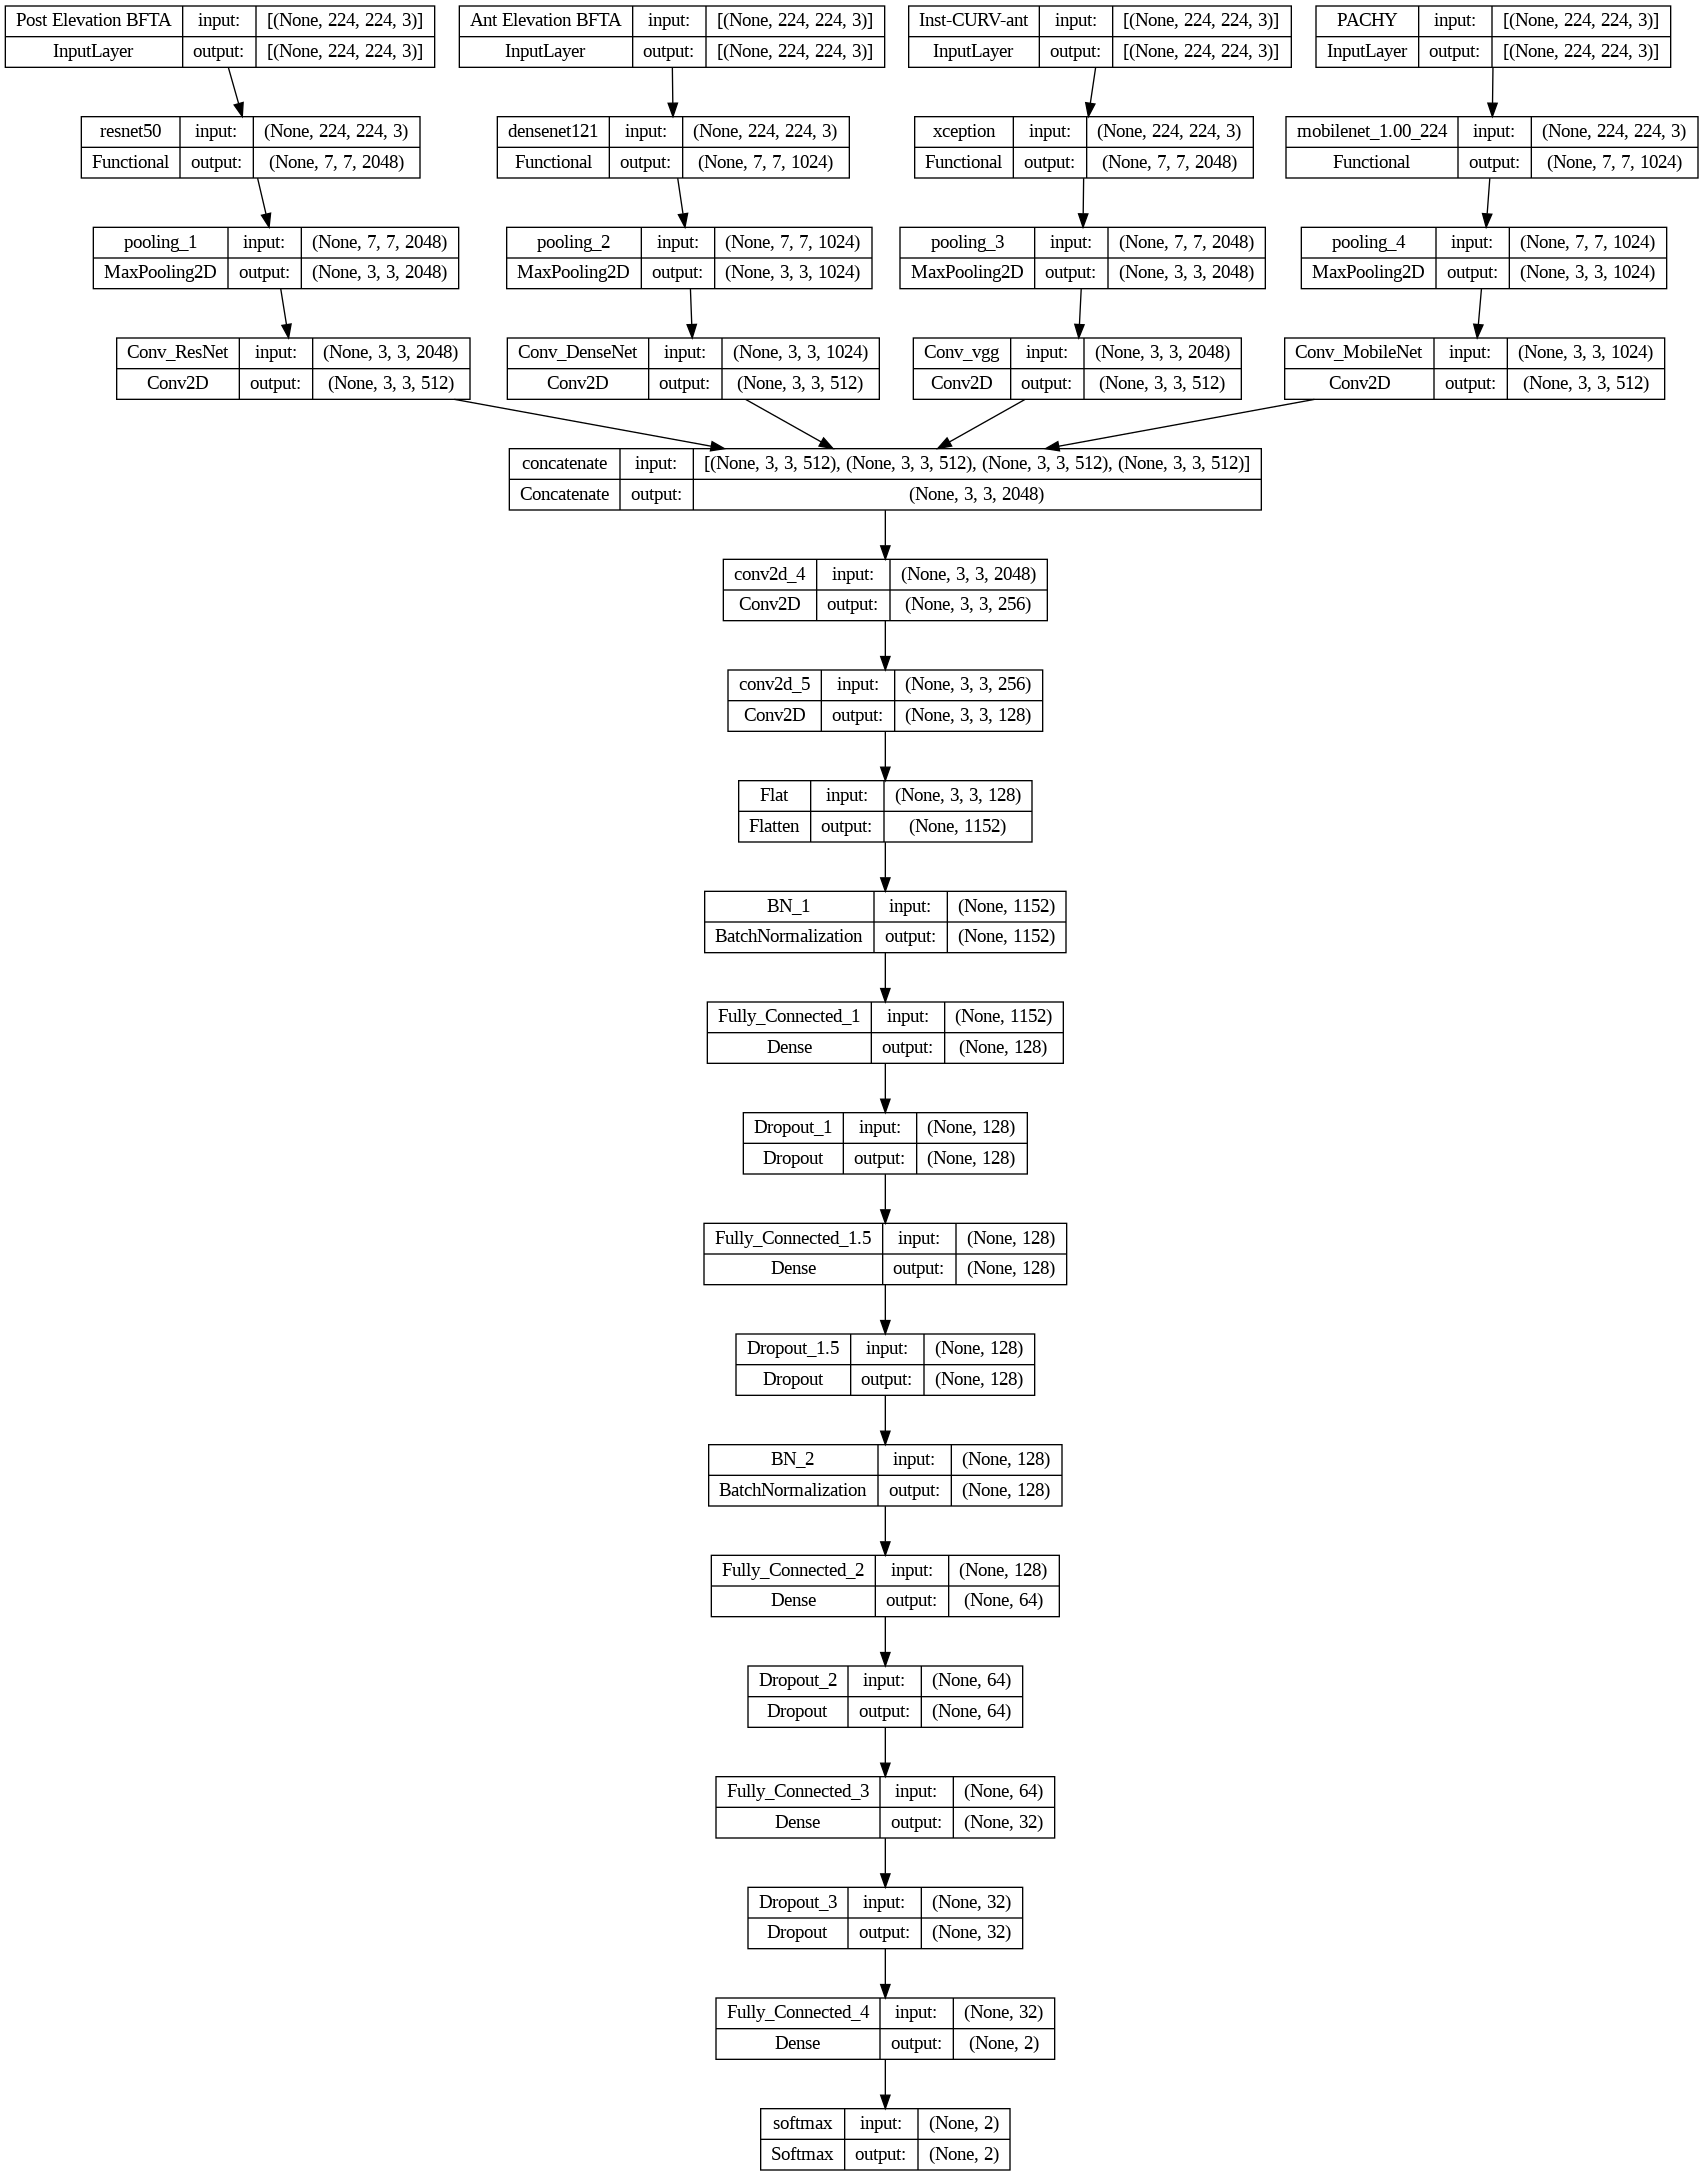

In [ ]:
keras.utils.plot_model(MODEL, to_file=path+"MultyBranch_model_noindex_v_f.png", show_shapes=True)

Load Networks, which Were Trained In The First Stage

In [ ]:
resnet = keras.models.load_model(path+"ResNet_Model(x1)_v2_b.h5.h5")
densenet = keras.models.load_model(path+"DenseNet121_Model(x2).h5")
xception = keras.models.load_model(path+"Xception_Model(x3)_v2_b.h5")##X1=>x3
mobileNet= keras.models.load_model(path+"MobileNet_Model(x4)_v3_b.h5")

Assign Branches (Filter Part) Weights and Freeze Certain Branches:

In [ ]:
#ResNet:
MODEL.layers[4].set_weights(np.array(resnet.layers[1].get_weights()))
MODEL.layers[4].trainable = True
MODEL.layers[12].set_weights(np.array(resnet.layers[3].get_weights()))
MODEL.layers[12].trainable = True
#DenseNet:
MODEL.layers[5].set_weights(np.array(densenet.layers[1].get_weights()))
MODEL.layers[5].trainable = False
MODEL.layers[13].set_weights(np.array(densenet.layers[3].get_weights()))
MODEL.layers[13].trainable = False
#Xception:
MODEL.layers[6].set_weights(np.array(xception.layers[1].get_weights()))
MODEL.layers[6].trainable = False
MODEL.layers[14].set_weights(np.array(xception.layers[3].get_weights()))
MODEL.layers[14].trainable = False
#MobileNet
MODEL.layers[7].set_weights(np.array(mobileNet.layers[1].get_weights()))
MODEL.layers[7].trainable = False
MODEL.layers[15].set_weights(np.array(mobileNet.layers[3].get_weights()))
MODEL.layers[15].trainable = False

<ipython-input-15-2ae23277a010>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  MODEL.layers[4].set_weights(np.array(resnet.layers[1].get_weights()))
<ipython-input-15-2ae23277a010>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  MODEL.layers[12].set_weights(np.array(resnet.layers[3].get_weights()))
<ipython-input-15-2ae23277a010>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must sp

Freeip Memory

In [ ]:
del resnet, densenet, xception, mobileNet
gc.collect()

7139

Training Setup

In [ ]:
###
adam = keras.optimizers.Adam(learning_rate=0.00001)
MODEL.compile(optimizer=adam,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
#drive.mount('/content/drive')
#MODEL.load_weights(path)

In [ ]:
Epoch = 50
reduceing_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.0000005)
best_save = ModelCheckpoint(path+'MultyBranch(2c)_v4_noindx_s3.h5',save_best_only=True,monitor='val_accuracy',mode='max')
history=MODEL.fit(x=[X1_tr,X2_tr,X3_tr,X4_tr],y=y_tr, batch_size=8 , epochs=Epoch,validation_data=([X1_te,X2_te,X3_te,X4_te],y_te) , callbacks=[best_save,reduceing_LR])
###

Epoch 1/50
398/398 [==============================] - 112s 169ms/step - loss: 0.1387 - accuracy: 0.9708 - val_loss: 0.8343 - val_accuracy: 0.9322 - lr: 1.0000e-05
Epoch 2/50
398/398 [==============================] - 63s 158ms/step - loss: 0.1048 - accuracy: 0.9786 - val_loss: 0.8230 - val_accuracy: 0.9350 - lr: 1.0000e-05
Epoch 3/50
398/398 [==============================] - 57s 144ms/step - loss: 0.1457 - accuracy: 0.9702 - val_loss: 0.8186 - val_accuracy: 0.9322 - lr: 1.0000e-05
Epoch 4/50
398/398 [==============================] - 57s 143ms/step - loss: 0.1217 - accuracy: 0.9758 - val_loss: 0.8183 - val_accuracy: 0.9294 - lr: 1.0000e-05
Epoch 5/50
398/398 [==============================] - 57s 142ms/step - loss: 0.1352 - accuracy: 0.9746 - val_loss: 0.8390 - val_accuracy: 0.9322 - lr: 1.0000e-05
Epoch 6/50
398/398 [==============================] - 57s 142ms/step - loss: 0.1573 - accuracy: 0.9711 - val_loss: 0.8194 - val_accuracy: 0.9350 - lr: 1.0000e-05
Epoch 7/50
398/398 [=======

## Training Diagrams of Loss And Accuracy

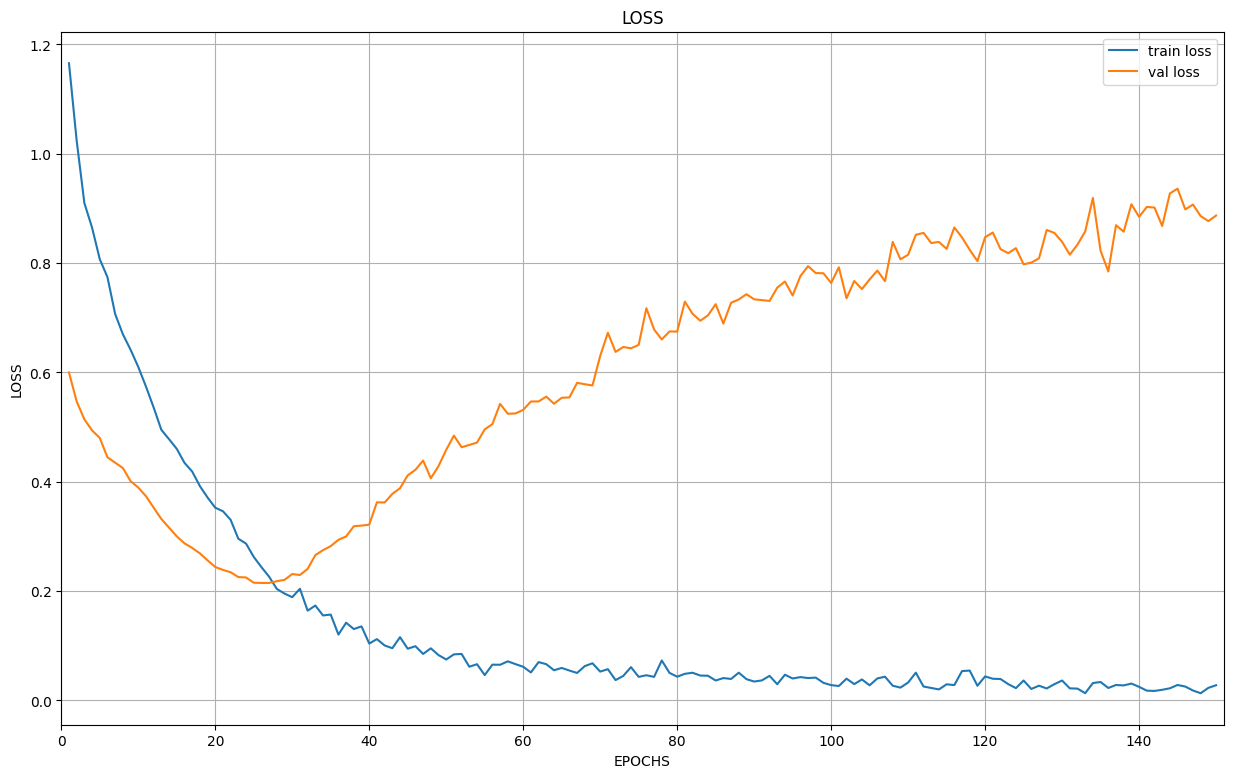

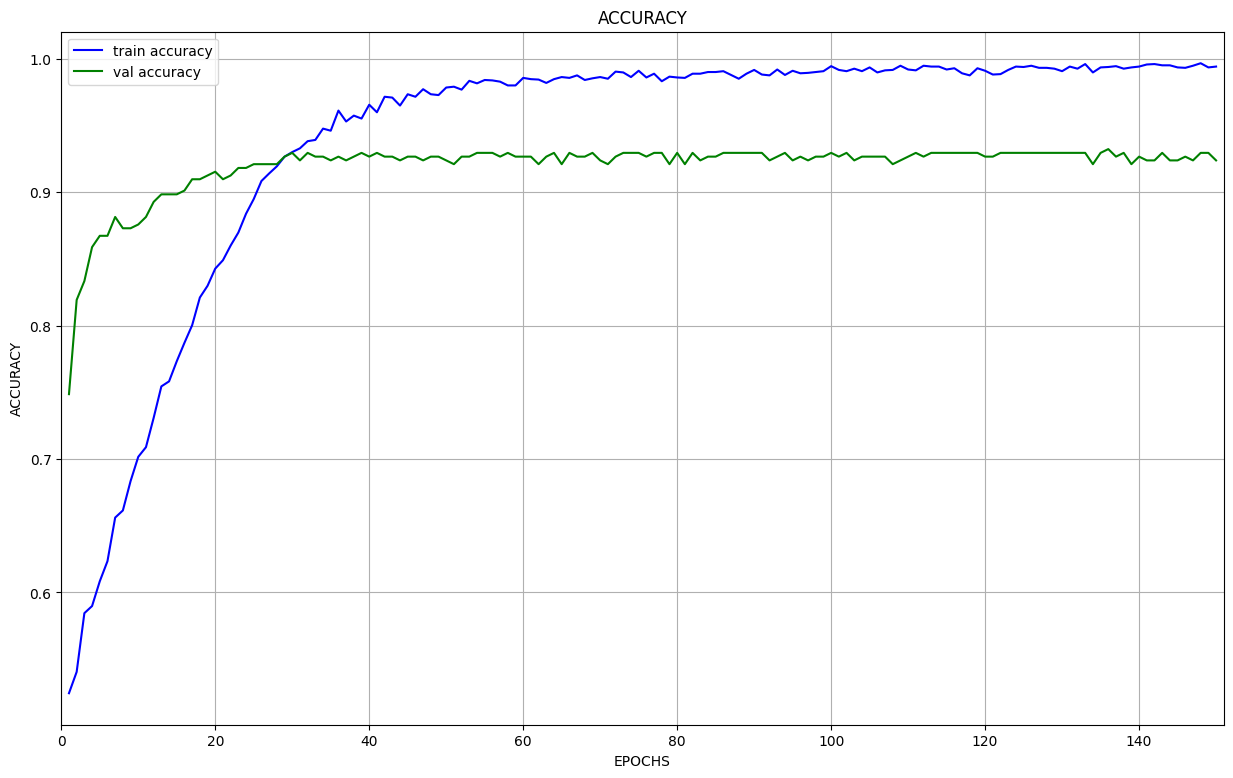

In [ ]:
###
#drive.mount('/content/drive')
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
EPOCH= range(1,Epoch+1)

plt.gcf().set_size_inches(15,9,forward=True)
plt.plot(EPOCH,loss)
plt.plot(EPOCH,val_loss)
plt.title('LOSS')
plt.xlabel('EPOCHS')
plt.ylabel('LOSS')
plt.grid()
plt.xlim([0,Epoch+1])
plt.legend(['train loss','val loss'])

plt.savefig(path +'EfficientNet_Model_Loss2.jpg')
plt.show()
print(3*'\n')
print(3*'\n')
plt.gcf().set_size_inches(15,9,forward=True)
plt.plot(EPOCH,acc,color='b')
plt.plot(EPOCH,val_acc,color='g')
plt.title('ACCURACY')
plt.xlabel('EPOCHS')
plt.ylabel('ACCURACY')
plt.grid()
plt.xlim([0,Epoch+1])
plt.legend(['train accuracy','val accuracy'])

plt.savefig(path+'EfficientNet_ModelAcc2.jpg')
plt.show()
###

In [ ]:
###
np.save(path+'loss2.npy',loss)
np.save(path+'val_loss2.npy',val_loss)
np.save(path+'acc2.npy',acc)
np.save(path+'val_acc2.npy',val_acc)
###

## Evaluate Final Multy-Branch Model At The of Third Phase

Load Model at The End of Third Stage

In [ ]:
MODEL= keras.models.load_model(path+'MultyBranch(2c)_noindx_final.h5')

Confusion Matrix

In [ ]:
###
# Simple function to decode labels from binary space:
def labeler(y):
  label = np.zeros(len(y))
  for i in range(len(y)):
    Max = max(y[i,:])
    for j in range(2):
      if (y[i,j]==Max):
        label[i]=j
  return label
# Decoding test data predicted labels from binary space:
y_te_p =labeler(MODEL.predict([X1_te,X2_te,X3_te,X4_te]))
y_te_d = labeler(y_te)
y_tr_p =labeler(MODEL.predict([X1_tr,X2_tr,X3_tr,X4_tr]))
y_tr_d = labeler(y_tr)
###

100/100 [==============================] - 35s 357ms/step


Confusion Matrix for Train Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


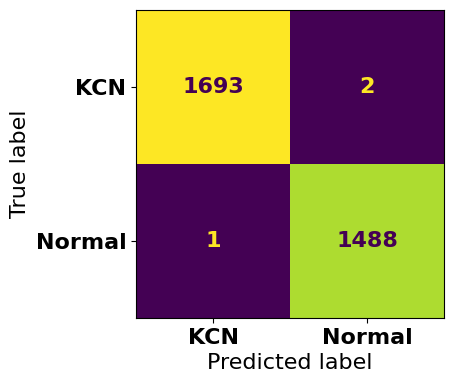

In [ ]:
###
drive.mount('/content/drive')
cm = confusion_matrix(y_tr_d,y_tr_p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['KCN','Normal'])
fig, ax = plt.subplots(figsize=(4,4))
font = {'family' : 'sans','weight' : 'bold','size'   : 16}
plt.rc('font', **font)
disp.plot(ax=ax, colorbar=False)
fig.savefig(path+'cm_tr_f_noindice.jpg')
###

Confusion Matrix for Test Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


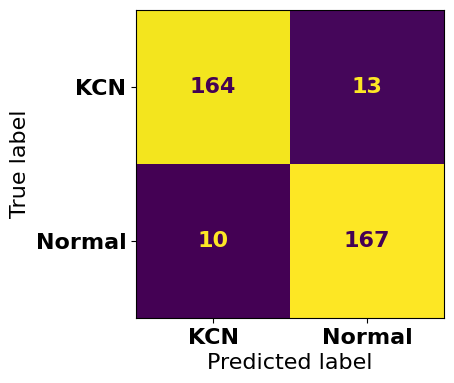

In [ ]:
###
drive.mount('/content/drive')
cm = confusion_matrix(y_te_d,y_te_p)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['KCN','Normal'])
fig, ax = plt.subplots(figsize=(4,4))
font = {'family' : 'sans','weight' : 'bold','size'   : 16}
plt.rc('font', **font)
disp.plot(ax=ax, colorbar=False)
fig.savefig(path+'cm_te_f_noindice.jpg')
###

Evaluate Model on The Train Data

In [ ]:
MODEL.evaluate([X1_tr,X2_tr,X3_tr,X4_tr],y_tr)

100/100 [==============================] - 37s 329ms/step - loss: 0.0053 - accuracy: 0.9991


[0.005285194609314203, 0.9990577697753906]

Evaluate Model on The Test Data

In [ ]:
MODEL.evaluate([X1_te,X2_te,X3_te,X4_te],y_te)

12/12 [==============================] - 4s 307ms/step - loss: 0.8230 - accuracy: 0.9350


[0.8230156302452087, 0.9350282549858093]